In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from IPython.display import display
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
#import face_recognition
import cv2
import time
import math

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
#global variables of the picture size
IMAGESIZE = [299, 299]  # width (0) Height (1) Images are resized to the this before getting push to the network.

In [4]:
# load up the meta data Image paths 
imdb_jsonFile = json.load(open("imdb_outputdata.json"))
wiki_jsonFile = json.load(open("wiki_outputdata.json"))
imdb_file_location = '../imdb/'
wiki_file_location = '../wiki/'
imdbLen = len(imdb_jsonFile)
wikiLen = len(wiki_jsonFile)
print(imdbLen, " ", wikiLen)

398305   44298


In [5]:
# usage print(get_face_locations('nm0000001_rm946909184_1899-5-10_1968.jpg'))
def get_face_locations(imagePath): 
    image = face_recognition.load_image_file(imagePath)
    return face_recognition.face_locations(image)

# crop the image to just read the face location  
def crop_image(image, face_loc):
    return image[face_loc[1]:face_loc[3], face_loc[0]:face_loc[2]]  #  1 , 3, 0, 2

# resize the image to match the 
def resize_image(image):
    dsize = (IMAGESIZE[0], IMAGESIZE[1]) # width (0) Height (1)  
    return cv2.resize(image, dsize)

In [41]:
#get the base gender model                                  
def gender_model(X,Y):
    base_model = keras.applications.Xception(weights='imagenet',include_top=False)
    new_model = base_model.output
    new_model = keras.layers.GlobalAveragePooling2D()(new_model)
    new_model = keras.layers.Dense(128,activation='relu')(new_model)
    new_model = keras.layers.Dense(Y.shape[1],activation='softmax')(new_model)
    model = keras.Model(inputs=base_model.input,outputs=new_model)
    model.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
             metrics=[keras.metrics.CategoricalAccuracy()])
    model.summary()
    return model         
#get the base age model                                   
def age_model(X,Y):
    base_model = keras.applications.Xception(weights='imagenet',include_top=False)
    new_model = base_model.output
    new_model = keras.layers.GlobalAveragePooling2D()(new_model)
    new_model = keras.layers.Dense(128,activation='relu')(new_model)
    new_model = keras.layers.Dense(Y.shape[1],activation='softmax')(new_model)
    model = keras.Model(inputs=base_model.input,outputs=new_model)
    model.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
             metrics=[keras.metrics.CategoricalAccuracy()])
    #model.summary()
    return model                                
                                   

In [7]:
# function to  fetch the IMAGES from X(start) to Y(end) and returns three arrays  
def read_images_gender_Age(start, end, JSON_File, images_location):
    X=[]
    Y=[]
    Z=[]
    corrupted_entry = 0 
    corrupted_age = 0 
    undetected_faces = 0
    for x in range(start, end):
        try:
            image = cv2.imread(images_location+JSON_File[x][3])    
                # if the image is one of the corrupted image, skip this entry 
            if(image is None or image.shape == (47,100,3) or image.shape == (1,1,3) or JSON_File[x][0] == "nan"):
                corrupted_entry +=1 
                continue
            face_loc = JSON_File[x][2]
            cropped_image = crop_image(image, face_loc)
            resized_image = resize_image(cropped_image)
            X.append(resized_image)
            Y.append(JSON_File[x][0]) # gender 
            Z.append(int(JSON_File[x][1])//5) # age
            #print(resized_image.shape)
            #plt.imshow(resized_image) 
            #plt.show()
            if(x % 1000 == 0):
                print('read one 1000')
        except Exception as e:
            print('ran into exception, skipping this photo entry, Error:', e)
            continue
            
    X = np.array(X)
    Y = np.array(Y).astype('float32')
    Y = keras.utils.to_categorical(Y)
    Z = np.array(Z).astype('float32')
    Z = keras.utils.to_categorical(Z, num_classes = 26)
    print('Read from ', start, ' to ', end, '. There were ',corrupted_entry)
    return X,Y,Z

#                       ['00','01','02','03','04','05']  
def read_images_byfile(files, JSON_File, images_location):
    X=[]
    Y=[]
    Z=[]
    corrupted_entry = 0 
    corrupted_age = 0 
    undetected_faces = 0
    count =0 
    for x in range(len(JSON_File)):
        if ((JSON_File[x][3]).split("/")[0] in files):
            try:
                image = cv2.imread(images_location+JSON_File[x][3])
                
                    # if the image is one of the corrupted image, skip this entry 
                if(image is None or image.shape == (47,100,3) or image.shape == (1,1,3) or JSON_File[x][0] == "nan"):
                    corrupted_entry +=1 
                    continue
                face_loc = JSON_File[x][2]
                cropped_image = crop_image(image, face_loc)
                resized_image = resize_image(cropped_image)
                X.append(resized_image)
                Y.append(JSON_File[x][0]) # gender 
                Z.append(int(JSON_File[x][1])//5) # age
                count +=1
                
                if(count % 1000 == 0):
                    print('read one 1000')
            except Exception as e:
                print('ran into exception, skipping this photo entry, Error:', e)
                continue
    
    X = np.array(X)
    Y = np.array(Y).astype('float32')
    Y = keras.utils.to_categorical(Y)
    Z = np.array(Z).astype('float32')
    Z = keras.utils.to_categorical(Z, num_classes = 26)
    print('read_images_by_file read', count, 'images')
    print('read these files' , str(files),'There were ',corrupted_entry)
    return X,Y,Z


#store the model and the history and which data entries were processed 
def store_history_model(model, history, start, end, duration, historyFilelocation, model_name, dataSetName):
    try:
        try:
            json_object = json.load(open(historyFilelocation))
        except:
            json_object = []

        storage_file = open(historyFilelocation, 'w')

        h5filename = str(start) + '-' + str(end)+ model_name + "-" + str(dataSetName)+ '.h5'
        h5_location = "./" + model_name + "/" + h5filename;

        model.save(h5_location);

        json_object.append({"h5Filename": h5filename,
                "start": start,
                "end": end,
                "duration": duration,
                "h5_location": h5_location, 
                "categorical_accuracy": str(history.history['categorical_accuracy']),          
                "val_categorical_accuracy": str(history.history['val_categorical_accuracy']),          
                "loss": str(history.history['loss']),
                "val_loss": str(history.history['val_loss'])
                           })

        json.dump(json_object, storage_file)
        storage_file.close()
    except Exception as e:
        print('ran into exception while trying to store model after fitting for index ', start, ' to index ', end, ' , Error:', e)
        return 0
    
    return 1
def store_history_model_byFiles(model, history, files, duration, historyFilelocation, model_name, dataSetName):
    try:
        try:
            json_object = json.load(open(historyFilelocation))
        except:
            json_object = []

        storage_file = open(historyFilelocation, 'w')

        h5filename = str(files)+ model_name + "-" + str(dataSetName)+ '.h5'
        h5_location = "./" + model_name + "/" + h5filename;

        model.save(h5_location);

        json_object.append({"h5Filename": h5filename,
                "files": str(files),
                "duration": duration,
                "h5_location": h5_location, 
                "categorical_accuracy": str(history.history['categorical_accuracy']),          
                "val_categorical_accuracy": str(history.history['val_categorical_accuracy']),          
                "loss": str(history.history['loss']),
                "val_loss": str(history.history['val_loss'])
                           })

        json.dump(json_object, storage_file)
        storage_file.close()
    except Exception as e:
        print('ran into exception while trying to store model Error:', e)
        return 0
    
    return 1

# pull the latest model checkpoint    
def pull_latest_model(historyFilelocation):
    try:
        json_object = json.load(open(historyFilelocation))
    except Exception as e:
        print('could not get the latest model, Error:', e)
        return 0
    print('trying to load model from', json_object[len(json_object)-1]['h5_location'])
    return keras.models.load_model(json_object[len(json_object)-1]['h5_location'])


def fit_model(model, X, Y, num_epochs):
    callback = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                            patience=1,
                                           verbose=1)
    batch_size = 40
    epochs = num_epochs
    validation_split = 0.2
    history = model.fit(X, Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = validation_split,
                    callbacks = [callback])
    return history


def train_gender_model(start, end, JSON_FILE, images_location, historyFile, dataSetName):
    try:
        print('Training gender model')
        start_time = time.time()
        X,Y,Z = read_images_gender_Age(start, end, JSON_FILE, images_location) #"../imdb/"
        latest_gender_model =  pull_latest_model(historyFile)  # "./genderHistory.json"
        if(latest_gender_model == 0):
            print("couldn't find a stored model, generating a new one")
            latest_gender_model = gender_model(X,Y)
        else:
            print("Found previously stored model from ", historyFile)
        
        history = fit_model(latest_gender_model, X, Y, 1)
        duration = (time.time() - start_time)
        store_history_model(latest_gender_model,history,start,end,duration,historyFile,'gender',dataSetName)
        
        
    except Exception as e:
        print('ran into exception while training index ', start, ' to index ', end, ' did not train this set, Error:', e)
        return 0
        
    return X,Y,Z

def train_age_model(start, end, JSON_FILE, images_location, historyFile, dataSetName):
    try:
        print('Training age model')
        start_time = time.time()
        X,Y,Z = read_images_gender_Age(start, end, JSON_FILE, images_location) #"../imdb/"
        latest_age_model =  pull_latest_model(historyFile)  # "./genderHistory.json"
        if(latest_age_model == 0):
            print("couldn't find a stored model, generating a new one")
            latest_age_model = age_model(X,Z)
        else:
            print("Found previously stored model from ", historyFile)
        
        history = fit_model(latest_age_model, X, Z, 2)
        duration = (time.time() - start_time)
        store_history_model(latest_age_model,history,start,end,duration,historyFile,'age',dataSetName)
          
    except Exception as e:
        print('ran into exception while training index ', start, ' to index ', end, ' did not train this set, Error:', e)
        return 0
        
    return X,Y,Z 

def train_gender_model_byfile(files, JSON_FILE, images_location, historyFile, dataSetName):
    try:
        print('Training gender model')
        start_time = time.time()
        X,Y,Z = read_images_byfile(files, JSON_FILE, images_location) #"../imdb/"
        latest_gender_model =  pull_latest_model(historyFile)  # "./genderHistory.json"
        if(latest_gender_model == 0):
            print("couldn't find a stored model, generating a new one")
            latest_gender_model = gender_model(X,Y)
        else:
            print("Found previously stored model from ", historyFile)
        
        history = fit_model(latest_gender_model, X, Y, 1)
        duration = (time.time() - start_time)
        store_history_model_byFiles(latest_gender_model,history,files,duration,historyFile,'gender',dataSetName)
        
        
    except Exception as e:
        print('ran into exception while training did not train this set, Error:', e)
        return 0
        
    return X,Y,Z 

def train_age_model_byfile(files, JSON_FILE, images_location, historyFile, dataSetName):
    try:
        print('Training age model')
        start_time = time.time()
        X,Y,Z = read_images_byfile(files, JSON_FILE, images_location) #"../imdb/"
        latest_age_model =  pull_latest_model(historyFile)  # "./genderHistory.json"
        if(latest_age_model == 0):
            print("couldn't find a stored model, generating a new one")
            latest_age_model = age_model(X,Z)
        else:
            print("Found previously stored model from ", historyFile)
            
        history = fit_model(latest_age_model, X, Z, 2)
        duration = (time.time() - start_time)
        store_history_model_byFiles(latest_age_model,history,files,duration,historyFile,'age',dataSetName)
          
    except Exception as e:
        print('ran into exception while training did not train this set, Error:', e)
        return 0
        
    return X,Y,Z 

#fetch the last 20 percent from the imdb(368,475  --  92,119) & wiki(49,862 --- 12,466) data sets, and run model.predict and see what's the accuracy rate.     
def test_model():
    return 0 

In [6]:
start = 0
end = 44298
current_data_set = "wiki"
gender_history_file = "./genderHistory.json"
age_history_file = "./ageHistory.json"
JSON_FILE = wiki_jsonFile
X,Y,Z = read_images_gender_Age(start, end, JSON_FILE, "../wiki/")
#curr_age_model = pull_latest_model(age_history_file)
curr_gender_model = pull_latest_model(gender_history_file)
"""""
if(curr_age_model == 0):
    print("couldn't find a stored age model, generating a new one")
    curr_age_model = age_model(X,Z)
history = fit_model(curr_age_model, X, Z, 1)
store_history_model(curr_age_model,history,start,end,"NA",age_history_file,'age',current_data_set)
"""""                    
if(curr_gender_model == 0):
    print("couldn't find a stored gender model, generating a new one")
    curr_gender_model = gender_model(X,Y)
history = fit_model(curr_gender_model, X, Y, 1)
store_history_model(curr_gender_model,history,start,end,"NA",gender_history_file,'gender',current_data_set)

read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
read one 1000
Read from  0  to  44298 . There were  902
trying to load model from ./gender/280000-320000gender-imdb.h5
868/868 [==============================] - 521s 600ms/step - loss: 0.1753 - categorical_accuracy: 0.9372 - val_loss: 0.1525 - val_categorical_accuracy: 0.9457


1

In [65]:
predicitions  = model.predict(X[:,:,:,:])
men_classified_as_women = []
women_classified_as_men = []
for x in range(len(Y)):
    if(float(Y[x][1]) == 1.0 and float(predicitions[x][1]) < 0.5):
        men_classified_as_women.append(x)
        
for x in range(len(Y)):
    if(float(Y[x][0]) == 1.0 and float(predicitions[x][0]) < 0.5):
        women_classified_as_men.append(x)

In [ ]:
print('men_classified_as_women ', len(men_classified_as_women))
print('women_classified_as_men ',  len(women_classified_as_men))

In [ ]:
for x in range(len(women_classified_as_men)):
    print('showing Image at index -', women_classified_as_men[x])
    print(Y[women_classified_as_men[x]])
    print(predicitions[women_classified_as_men[x]])
    plt.imshow(X[women_classified_as_men[x],:,:,:])
    plt.show()

In [ ]:
files = ["00","01","02","03",""]
duration = "NA"
current_data_set = "wiki"
gender_history_file = "./genderHistory.json"
age_history_file = "./ageHistory.json"
X,Y,Z = read_images_byfile(files, wiki_jsonFile, "../wiki/")
curr_age_model = pull_latest_model(age_history_file)
curr_gender_model = pull_latest_model(gender_history_file)
if(curr_age_model == 0):
    print("couldn't find a stored age model, generating a new one")
    curr_age_model = age_model(X,Z)
history = fit_model(curr_age_model, X, Z, 2)
store_history_model_byFiles(curr_age_model,history,files,duration,age_history_file,'age',current_data_set)

if(curr_gender_model == 0):
    print("couldn't find a stored gender model, generating a new one")
    curr_gender_model = gender_model(X,Y)
history = fit_model(curr_gender_model, X, Y, 2)
store_history_model_byFiles(curr_gender_model,history,files,duration,gender_history_file,'gender',current_data_set)

In [10]:
# testing set ... to evaluate success 
A, B, C = read_images_gender_Age(320000, 321000, imdb_jsonFile, "../imdb/")
last_gender_model = keras.models.load_model("./gender/0-40000gender-imdb.h5");
last_gender_model.evaluate(A, B, verbose=1)

read one 1000
Read from  320000  to  321000 . There were  0
32/32 [==============================] - 59s 2s/step - loss: 0.6565 - categorical_accuracy: 0.8180


[0.6564984321594238, 0.8180000185966492]

In [43]:
A.shape
B.shape
C.shape

(1000, 26)

In [29]:

last_gender_model = keras.models.load_model("./gender/280000-320000gender-imdb.h5")

In [ ]:
last_gender_model = gender_model(A,B)

In [30]:
last_gender_model.evaluate(A, B, verbose=1)

32/32 [==============================] - 61s 2s/step - loss: 0.4439 - categorical_accuracy: 0.8200


[0.4439134895801544, 0.8199999928474426]

<p>---------------------------------------------------------------------------------------------<p>
<h1> Accuracy and loss graph for gender </h1>
<h4> the graphs are shown after training a training set not after each epoch, each training set consisted of 40k image</h4>

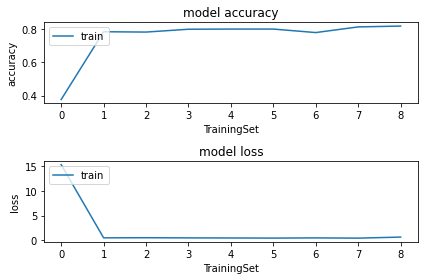

In [31]:
loss = [15.301619529724121, 0.5077489614486694, 0.5287086963653564, 0.49600136280059814, 0.4787052869796753, 0.45445501804351807, 0.49454060196876526, 0.4473538100719452, 0.6564984321594238]
accuracy = [0.37700000405311584,  0.7839999794960022, 0.7820000052452087, 0.7990000247955322, 0.800000011920929,  0.800000011920929, 0.7789999842643738, 0.8130000233650208, 0.8180000185966492]
plt.subplot(211)
plt.plot(accuracy)
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('TrainingSet')
plt.legend(['train', 'Test'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(loss)
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('TrainingSet')
plt.legend(['train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show() 



32/32 [==============================] - 59s 2s/step - loss: 2.1739 - categorical_accuracy: 0.1950
loss: [31.999034881591797, 2.3878910541534424, 2.7128188610076904, 2.3686420917510986, 2.0899105072021484, 2.2499353885650635, 2.058628797531128, 1.9946621656417847, 1.9985848665237427, 2.1739301681518555]
Accuracy: [0.012000000104308128, 0.23100000619888306, 0.18000000715255737, 0.2150000035762787, 0.27300000190734863, 0.1940000057220459, 0.24699999392032623, 0.27000001072883606, 0.3059999942779541, 0.19499999284744263]


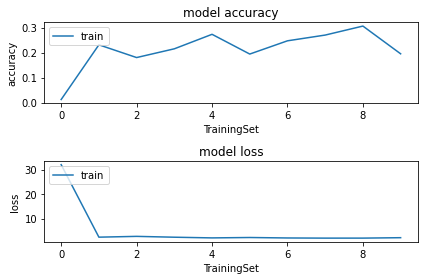

In [42]:
loss = []
accuracy = []
model = age_model(A,C)
score = model.evaluate(A, C, verbose=1)
loss.append(score[0])
accuracy.append(score[1])
age_history = json.load(open("ageHistory.json"))
for model in age_history:
    model = keras.models.load_model("./age/"+model['h5Filename'])
    score = model.evaluate(A, C, verbose=1)
    loss.append(score[0])
    accuracy.append(score[1])
    
print("loss:", loss)
print("Accuracy:", accuracy)

plt.subplot(211)
plt.plot(accuracy)
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('TrainingSet')
plt.legend(['train', 'Test'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(loss)
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('TrainingSet')
plt.legend(['train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()